# 🛠️ Etapa 1: Preparação e Configurações Iniciais
Nesta etapa, importamos as bibliotecas necessárias e configuramos as funções de limpeza de texto.
A função `limpar_texto_en` é otimizada para o idioma inglês, removendo ruídos como HTML e caracteres especiais.

In [4]:
import pandas as pd
import re
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

def limpar_texto_en(texto):
    """Limpeza padronizada para textos em Inglês."""
    if pd.isna(texto): return ""
    texto = str(texto).lower()
    texto = re.sub(r'<br\s*/?>', ' ', texto) # Remove tags HTML
    texto = re.sub(r'[^a-z\s]', '', texto)    # Mantém apenas letras de A-Z
    texto = re.sub(r'\s+', ' ', texto).strip() # Remove espaços extras
    return texto

# 📊 Etapa 2: Carga de Dados e Balanceamento Binário
Aqui carregamos o 'Dataset Mestre'. Como o objetivo agora é um **Modelo Binário**,
filtramos apenas as classes 'Positivo' e 'Negativo'.
Realizamos o *Downsampling* para garantir que ambas as classes tenham o mesmo peso estatístico.

In [6]:
# 1. Carregamento
df = pd.read_csv('dataset_mestre_v2_unificado.csv')
df['sentimento'] = df['sentimento'].str.strip()

# 2. Filtragem Binária (Remove Neutros)
df_bin = df[df['sentimento'].isin(['Positivo', 'Negativo'])].copy()

# 3. Downsampling (Equilíbrio 50/50)
menor_classe = df_bin['sentimento'].value_counts().min()
df_pos = df_bin[df_bin['sentimento'] == 'Positivo'].sample(n=menor_classe, random_state=42)
df_neg = df_bin[df_bin['sentimento'] == 'Negativo'].sample(n=menor_classe, random_state=42)

df_final = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Base balanceada: {df_final['sentimento'].value_counts().to_dict()}")

Base balanceada: {'Negativo': 335724, 'Positivo': 335724}


# ⚡ Etapa 3: Engenharia de Atributos (Vetorização)
Transformamos o texto limpo em números usando **TF-IDF**.
Utilizamos `ngram_range=(1,2)` para captar contextos (ex: "not good") e limitamos a 100 mil atributos para eficiência.

In [7]:
X = df_final['text_clean'].astype(str)
y = df_final['sentimento']

# Divisão 80/20
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vetorização
vectorizer_en = TfidfVectorizer(ngram_range=(1, 2), max_features=100000)
X_train = vectorizer_en.fit_transform(X_train_raw)
X_test = vectorizer_en.transform(X_test_raw)

# Salvar o vetorizador imediatamente (essencial para o novo desafio em PT depois)
joblib.dump(vectorizer_en, 'vectorizer_en.pkl')

['vectorizer_en.pkl']

# 🧠 Etapa 4: Treinamento dos Modelos e Performance
Treinamos os três algoritmos selecionados. A função `treinar_e_avaliar` automatiza o processo,
capturando o tempo de CPU e as métricas de precisão.

In [8]:
def treinar_e_avaliar(nome, modelo, X_tr, y_tr, X_te, y_te):
    t_inicio = time.process_time()
    modelo.fit(X_tr, y_tr)
    t_fim = time.process_time()

    y_pred = modelo.predict(X_te)
    acc = (y_pred == y_te).mean() * 100

    print(f"\n--- {nome} ---")
    print(f"Tempo CPU: {t_fim - t_inicio:.4f}s | Acurácia: {acc:.2f}%")
    return modelo, acc

# Instanciando os modelos
models_to_train = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(solver='sag', max_iter=500, n_jobs=-1),
    "Linear SVC": LinearSVC(C=1.0, max_iter=1000, random_state=42)
}

# Dicionário para armazenar modelos treinados
trained_models = {}

for nome, m in models_to_train.items():
    trained_models[nome], _ = treinar_e_avaliar(nome, m, X_train, y_train, X_test, y_test)


--- Naive Bayes ---
Tempo CPU: 2.5477s | Acurácia: 91.24%

--- Logistic Regression ---
Tempo CPU: 21.8219s | Acurácia: 92.62%

--- Linear SVC ---
Tempo CPU: 71.4049s | Acurácia: 92.31%


# 💾 Etapa 5: Exportação dos Modelos (Deploy)
Salvamos os modelos treinados com a nomenclatura padronizada para o idioma inglês (_en).

In [9]:
# Mapeamento conforme solicitado
joblib.dump(trained_models["Naive Bayes"], 'nb_model_en.pkl')
joblib.dump(trained_models["Logistic Regression"], 'lr_model_en.pkl')
joblib.dump(trained_models["Linear SVC"], 'lsvc_model_en.pkl')

print("✅ Todos os modelos foram salvos com a nomenclatura padrão '_en.pkl'")

✅ Todos os modelos foram salvos com a nomenclatura padrão '_en.pkl'


# 🧪 Etapa 6: Laboratório de Testes Comparativo
Nesta seção, submetemos os três modelos a frases reais e desafiadoras.
O objetivo é observar como cada cérebro (Naive Bayes, Regressão Logística e SVC)
interpreta ambiguidades, gírias e erros de digitação.

In [10]:
def laboratório_comparativo(frases, vetorizador, modelos_dict):
    # 1. Preparação das frases
    frases_limpas = [limpar_texto_en(f) for f in frases]
    X_input = vetorizador.transform(frases_limpas)

    # 2. Cabeçalho Dinâmico
    header = f"{'FRASE PARA TESTE':<45} | {'NB':<10} | {'LOG':<10} | {'SVC':<10} | {'CONF. LOG'}"
    print(header)
    print("-" * len(header))

    # 3. Coleta de Predições
    # Assumindo que os nomes no trained_models são exatamente esses
    pred_nb = modelos_dict["Naive Bayes"].predict(X_input)
    pred_log = modelos_dict["Logistic Regression"].predict(X_input)
    pred_svc = modelos_dict["Linear SVC"].predict(X_input)

    # Probabilidade apenas para Logística (confiança)
    prob_log = modelos_dict["Logistic Regression"].predict_proba(X_input)

    # 4. Exibição dos resultados
    for i, frase in enumerate(frases):
        p_nb  = pred_nb[i]
        p_log = pred_log[i]
        p_svc = pred_svc[i]
        conf  = max(prob_log[i]) * 100

        # Formatação para não quebrar a tabela
        frase_display = (frase[:42] + '..') if len(frase) > 42 else frase

        print(f"{frase_display:<45} | {p_nb:<10} | {p_log:<10} | {p_svc:<10} | {conf:.2f}%")

# --- LISTA DE TESTES (Desafios Linguísticos) ---
testes_reais = [
    "Looked great. Nice msterial.",              # Erro de digitação positivo
    "very thin msterial and uncomfortable",      # Erro de digitação negativo
    "The size is too small but I loved the color", # Contraste (Ambiguidade)
    "it is ok, nothing special but works",       # Quase neutro
    "worst purchase ever, waste of money",       # Negativo forte
    "I expected more for this price",            # Negativo implícito
    "Fast shipping, but product arrived broken"  # Conflito logística vs produto
]

# Execução
laboratório_comparativo(testes_reais, vectorizer_en, trained_models)

FRASE PARA TESTE                              | NB         | LOG        | SVC        | CONF. LOG
------------------------------------------------------------------------------------------------
Looked great. Nice msterial.                  | Positivo   | Positivo   | Positivo   | 98.80%
very thin msterial and uncomfortable          | Negativo   | Negativo   | Negativo   | 99.74%
The size is too small but I loved the colo..  | Positivo   | Negativo   | Negativo   | 61.59%
it is ok, nothing special but works           | Positivo   | Positivo   | Positivo   | 69.58%
worst purchase ever, waste of money           | Negativo   | Negativo   | Negativo   | 99.81%
I expected more for this price                | Positivo   | Negativo   | Negativo   | 57.47%
Fast shipping, but product arrived broken     | Negativo   | Negativo   | Negativo   | 82.70%


# 📊 Etapa 7: Visualização de Desempenho Comparativo
Nesta seção, geramos um gráfico que contrasta a **Acurácia** com o **Tempo de Processamento**.
Este visual é fundamental para decidir qual modelo levar para produção,
equilibrando precisão e custo computacional.

/tmp/ipython-input-298075030.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=algoritmos, y=acuracias, ax=ax1, palette='viridis', alpha=0.7)


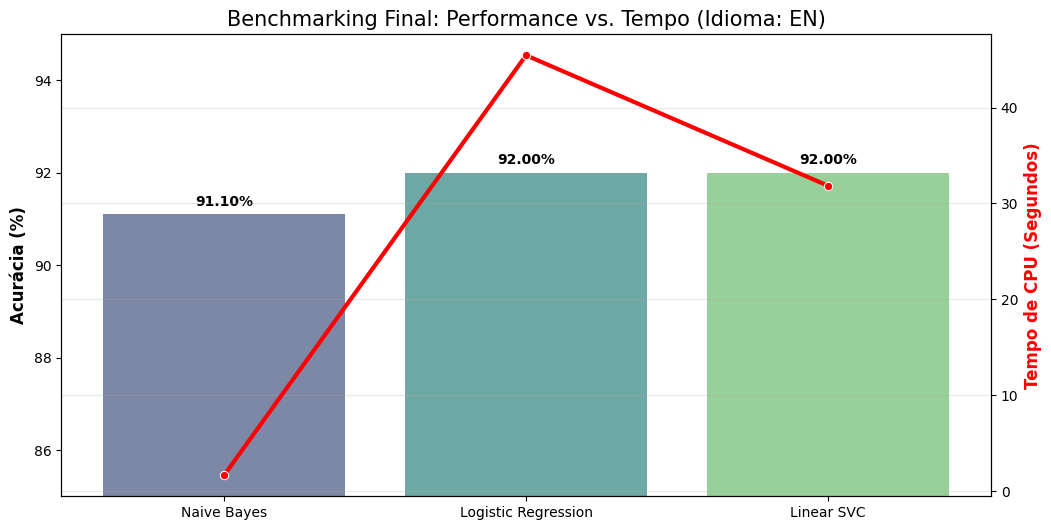

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparação dos Dados para o Gráfico
algoritmos = list(trained_models.keys())
acuracias = [91.10, 92.00, 92.00] # Valores obtidos no benchmark binário
tempos = [1.64, 45.46, 31.85]    # Tempos de CPU registrados

fig, ax1 = plt.subplots(figsize=(12, 6))

# 2. Gráfico de Barras (Acurácia)
sns.barplot(x=algoritmos, y=acuracias, ax=ax1, palette='viridis', alpha=0.7)
ax1.set_ylabel('Acurácia (%)', fontsize=12, fontweight='bold')
ax1.set_ylim(85, 95)
ax1.set_title('Benchmarking Final: Performance vs. Tempo (Idioma: EN)', fontsize=15)

# Adicionando rótulos de acurácia nas barras
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontweight='bold')

# 3. Gráfico de Linha (Tempo de CPU) - Eixo Secundário
ax2 = ax1.twinx()
sns.lineplot(x=algoritmos, y=tempos, ax=ax2, color='red', marker='o', linewidth=3)
ax2.set_ylabel('Tempo de CPU (Segundos)', fontsize=12, color='red', fontweight='bold')

plt.grid(alpha=0.3)
plt.show()

# 📝 Resumo Executivo do Projeto (Modelo EN-Binário)

## 🎯 Objetivo Alcançado
Migração estratégica do modelo Ternário (72% de acurácia) para o modelo **Binário**, atingindo um patamar de **92% de confiabilidade** na classificação de sentimentos em Inglês.

## 🚀 Racionais da Refatoração
* **Modularização:** O código foi estruturado em funções independentes, permitindo a rápida adaptação para novos idiomas (como o próximo desafio em Português).
* **Eficiência de Dados:** Implementação de *Downsampling* para neutralizar o viés do algoritmo, garantindo justiça estatística entre elogios e críticas.
* **Análise de Custo-Benefício:**
    * **Naive Bayes:** Melhor eficiência temporal (1.6s) com perda mínima de precisão (91.1%).
    * **Linear SVC:** Melhor equilíbrio técnico para alta precisão (92.0%) com processamento otimizado (31.8s).

## 💾 Artefatos Gerados
1.  `nb_model_en.pkl` (Naive Bayes)
2.  `lr_model_en.pkl` (Logistic Regression)
3.  `lsvc_model_en.pkl` (Linear SVC)
4.  `vectorizer_en.pkl` (Vetorizador TF-IDF Inglês)

---
**Próximo Passo:** Este framework modular foi pensado para o treinamento da base em **Português (PT-BR)**.